In [8]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import itertools
import datetime
from math import ceil, isnan
from params import *
import sys
import seaborn as sns
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
try:
    import catheat
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install git+git://github.com/schlegelp/catheat@master
    import catheat

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [28]:
search_results = pd.read_csv('search_results/random_search_10564.csv', index_col = 0)
print(len(search_results))
print(search_results['transition_score'].min())
print(search_results['chi-squared_score'].min())
print(search_results['indv_score'].min())
print(search_results['similarity_score'].min())
print()
print(search_results['transition_score'].max())
print(search_results['chi-squared_score'].max())
print(search_results['indv_score'].max())
print(search_results['similarity_score'].max())
search_results.head()

346
0.09946630150079727
0.003355186665430665
0.04841247573494911
0.0

9.460980415344238
10.424381256103516
2.059527635574341
0.5434942841529846


,batch_size,chi-squared_score,embed_size,head_size,indv_score,lr,mem_slots,n_embeddings,num_blocks,num_filters,num_heads,out_channels,similarity_score,temperature,transition_score
0,227.0,0.145391,16.0,20.0,0.328025,7.0,6.0,9.0,11.0,16.0,17.0,19.0,0.373409,90.0,0.228890
1,149.0,0.223790,19.0,6.0,0.519817,3.0,14.0,2.0,12.0,8.0,17.0,16.0,0.013253,99.0,1.000000
2,225.0,0.223817,20.0,1.0,0.519817,3.0,12.0,2.0,6.0,14.0,20.0,19.0,0.013253,91.0,1.000000
3,88.0,0.209174,14.0,9.0,0.462547,2.0,7.0,6.0,11.0,14.0,19.0,17.0,0.050699,86.0,0.461189
4,186.0,0.223817,6.0,17.0,0.519817,2.0,3.0,9.0,4.0,13.0,20.0,8.0,0.013253,49.0,1.000000


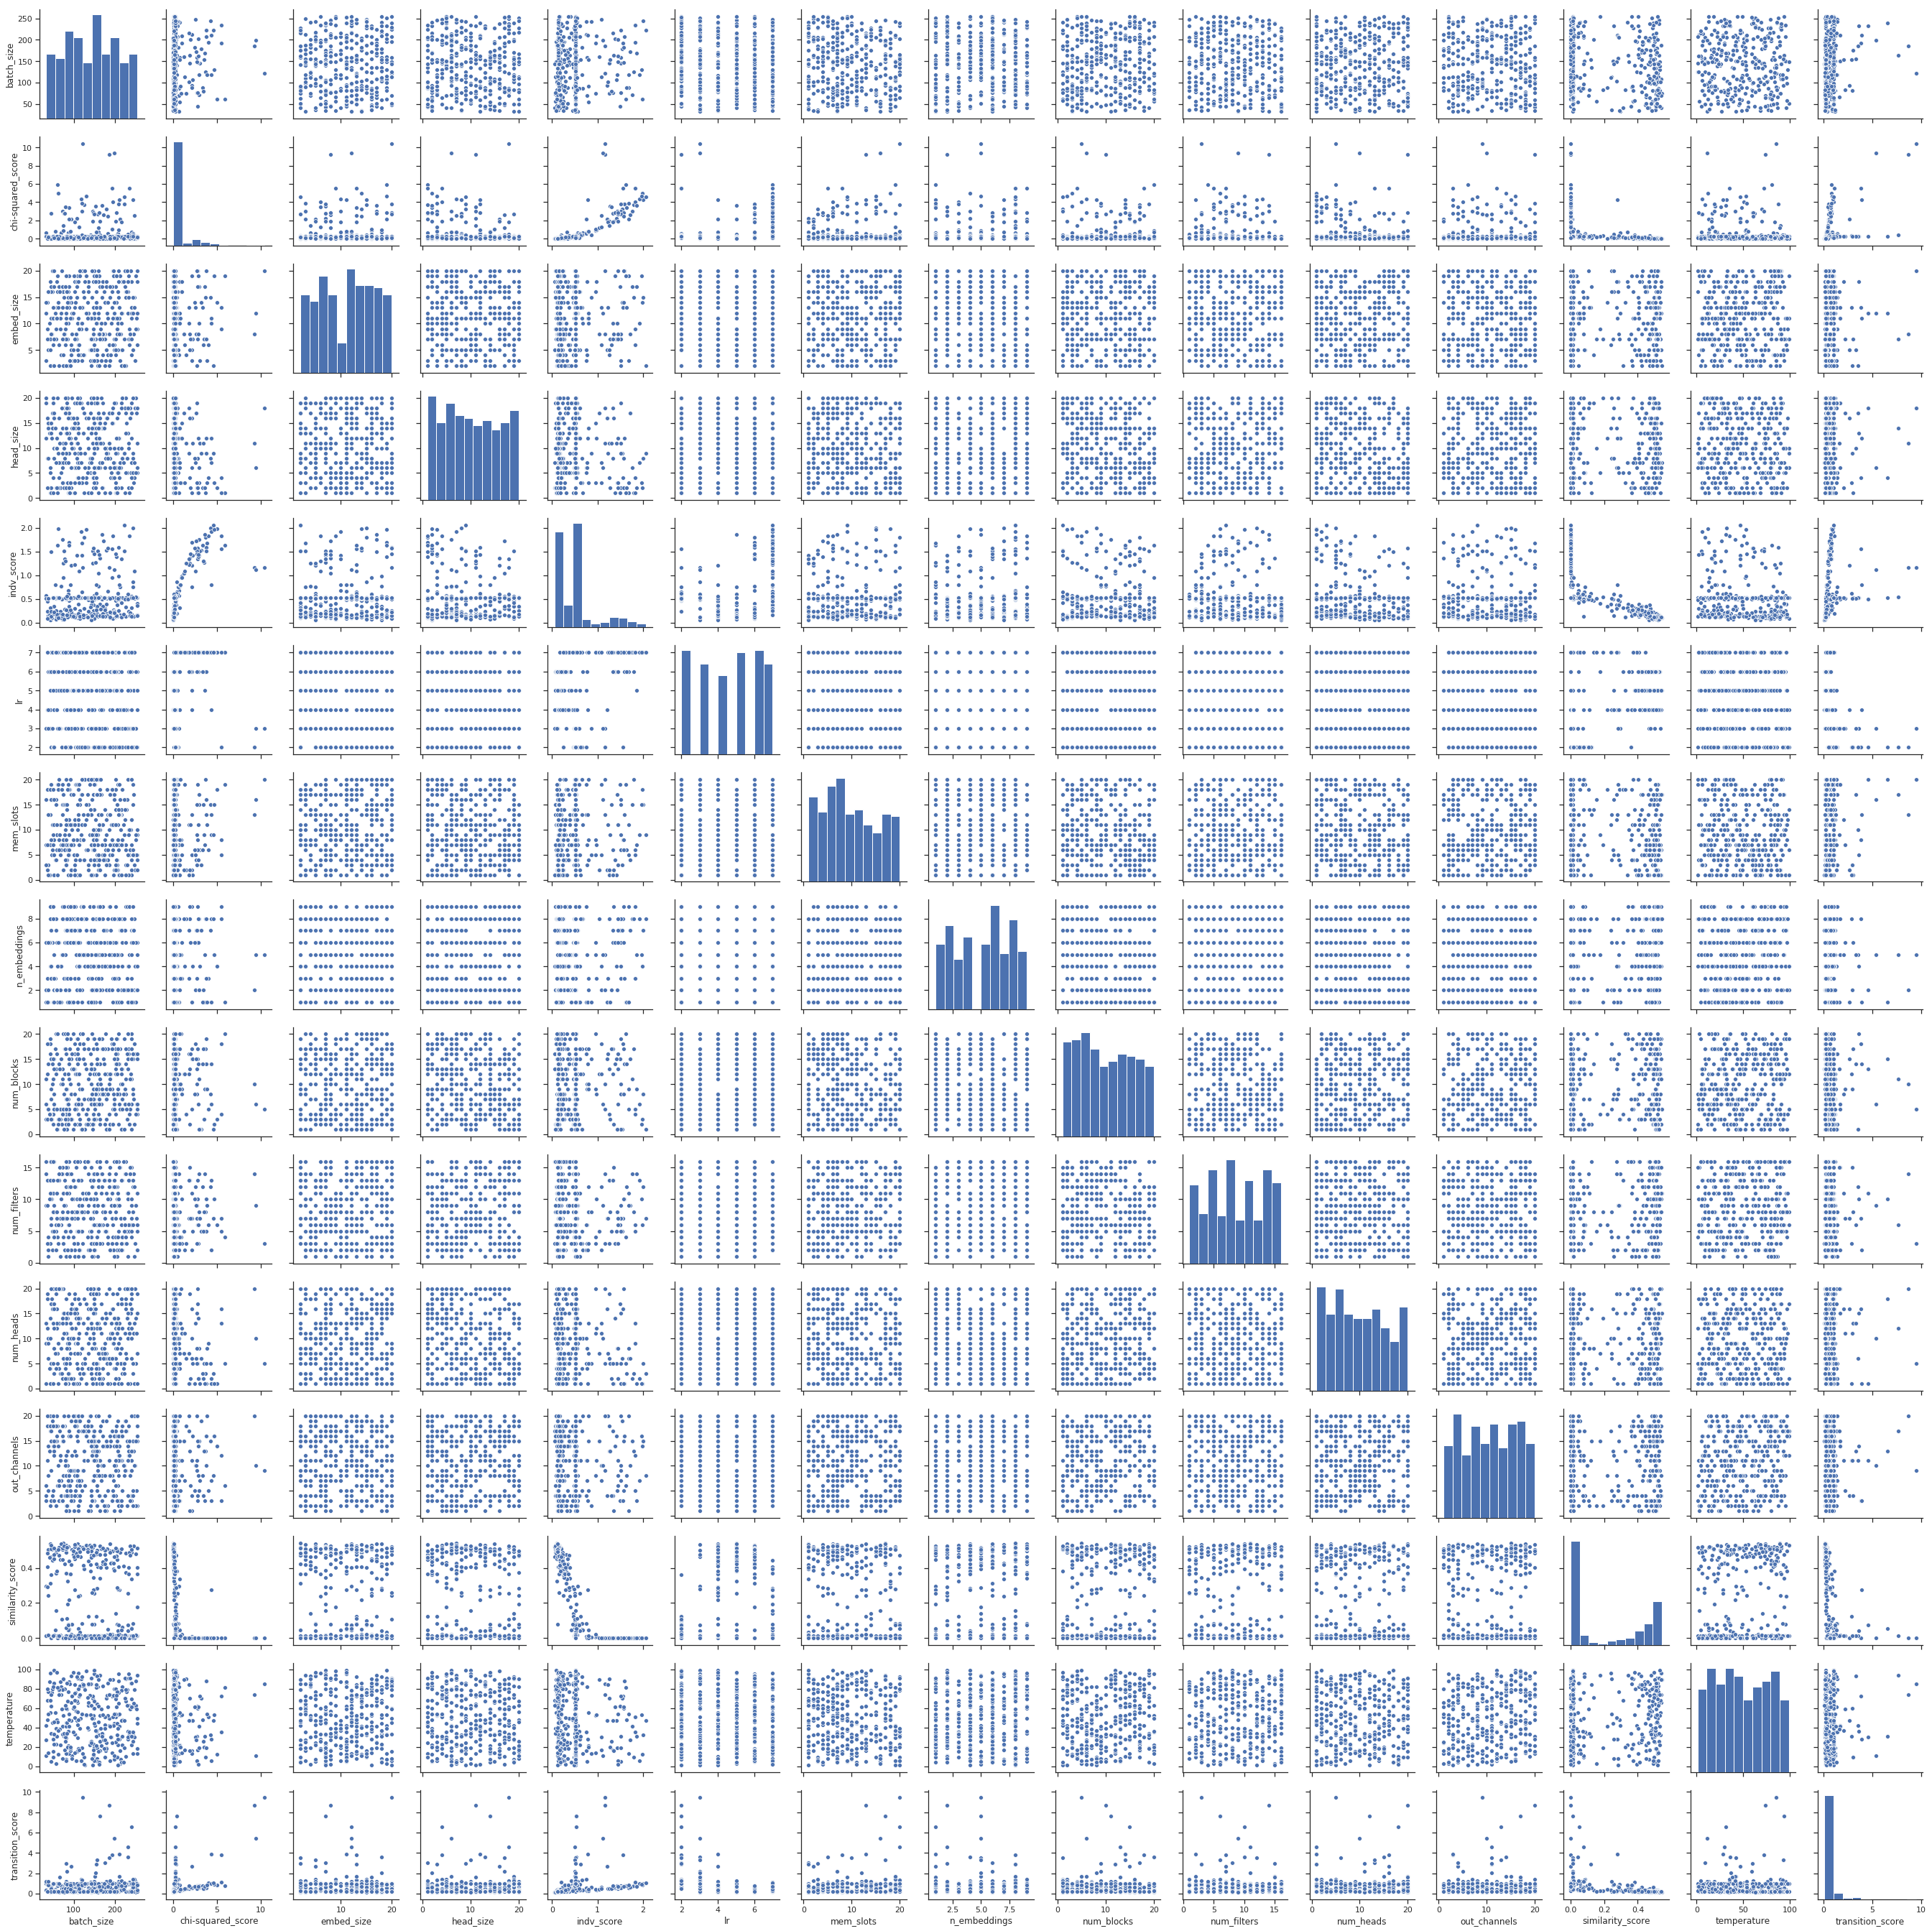

In [11]:
sns.set(style="ticks")

sns.pairplot(search_results)

Index(['batch_size', 'embed_size', 'head_size', 'lr', 'mem_slots',
       'n_embeddings', 'num_blocks', 'num_filters', 'num_heads',
       'out_channels', 'temperature'],
      dtype='object')
Intercept: 
 1.2181729374794688
Coefficients: 
 [ 1.99846585e-03 -7.53433557e-03  1.26574533e-02 -2.38929721e-01
  3.26721294e-02 -2.27442960e-02  4.60750173e-03 -9.65235806e-03
  1.01103760e-02  3.44917619e-03 -9.00981577e-05]
0.22267031854547684
batch_size      52.848207
embed_size       4.603996
head_size        5.138561
lr               1.523238
mem_slots        4.902402
n_embeddings     2.175549
num_blocks       5.045708
num_filters      3.859634
num_heads        5.124277
out_channels     4.967757
temperature     24.293762
dtype: float64


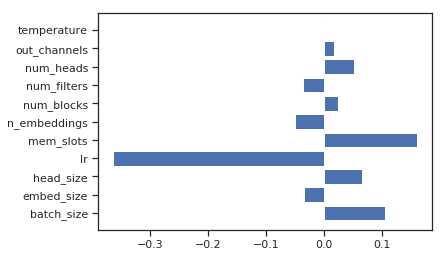

In [14]:
X = search_results.loc[:, ~search_results.columns.isin(['transition_score', 'chi-squared_score', 'indv_score', 'similarity_score'])]
print(X.columns)
Y = search_results['transition_score']
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(X, Y))
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ * X.mad(), 
    tick_label=X.columns
)
plt.show()

Intercept: 
 0.12653998214048945
Coefficients: 
 [ 0.00211275  0.01555411 -0.03868851  0.19524274  0.01637257 -0.0195164
 -0.00957734 -0.00324727 -0.03351878  0.00624487 -0.00259667]
0.12496303963750421
batch_size      52.848207
embed_size       4.603996
head_size        5.138561
lr               1.523238
mem_slots        4.902402
n_embeddings     2.175549
num_blocks       5.045708
num_filters      3.859634
num_heads        5.124277
out_channels     4.967757
temperature     24.293762
dtype: float64


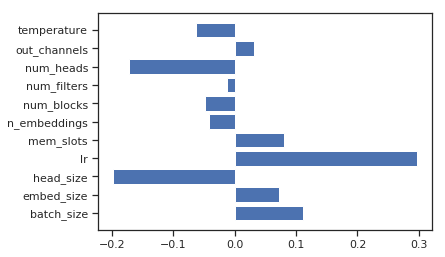

In [15]:
Y = search_results['chi-squared_score']
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(X, Y))
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ * X.mad(), 
    tick_label=X.columns
)
plt.show()

Intercept: 
 0.47056674947018706
Coefficients: 
 [ 0.00073223  0.00552603 -0.01332751  0.05599313  0.00047973 -0.00045762
 -0.00397456  0.00082747 -0.01380766  0.00221753 -0.0019689 ]
0.1372118085854772
batch_size      52.848207
embed_size       4.603996
head_size        5.138561
lr               1.523238
mem_slots        4.902402
n_embeddings     2.175549
num_blocks       5.045708
num_filters      3.859634
num_heads        5.124277
out_channels     4.967757
temperature     24.293762
dtype: float64


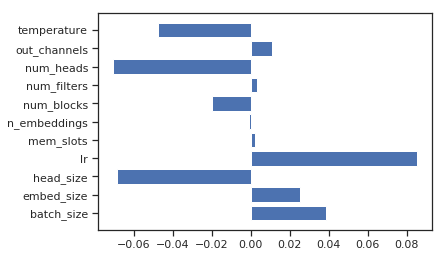

In [16]:
Y = search_results['indv_score']
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(X, Y))
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ * X.mad(), 
    tick_label=X.columns
)
plt.show()

Intercept: 
 0.03821113589150557
Coefficients: 
 [-3.47049369e-04 -1.79713200e-03 -7.95144954e-04  4.09012385e-02
 -3.13413011e-03  4.12396233e-03  1.40570500e-03  3.40233482e-03
  1.66169614e-06 -1.40876785e-03  1.07320958e-03]
0.15368007451675259
batch_size      52.848207
embed_size       4.603996
head_size        5.138561
lr               1.523238
mem_slots        4.902402
n_embeddings     2.175549
num_blocks       5.045708
num_filters      3.859634
num_heads        5.124277
out_channels     4.967757
temperature     24.293762
dtype: float64


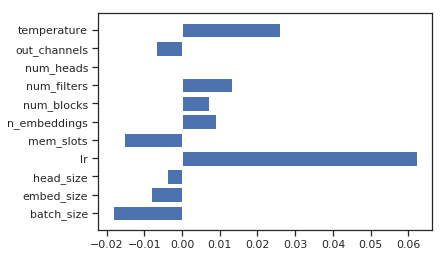

In [17]:
Y = search_results['similarity_score']
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(X, Y))
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ * X.mad(), 
    tick_label=X.columns
)
plt.show()

(346,)
count    346.000000
mean       4.966441
std        3.675723
min        1.621691
25%        3.283989
50%        3.950499
75%        4.400665
max       34.251000
dtype: float64
batch_size           96.000000
chi-squared_score     0.029918
embed_size            8.000000
head_size            20.000000
indv_score            0.124354
lr                    5.000000
mem_slots            11.000000
n_embeddings          6.000000
num_blocks            3.000000
num_filters           8.000000
num_heads            17.000000
out_channels         12.000000
similarity_score      0.077522
temperature          11.000000
transition_score      0.431095
Name: 68, dtype: float64
Intercept: 
 4.186159518855455
Coefficients: 
 [ 0.0071434   0.01538541 -0.07291712  0.17908253  0.06752468 -0.04825099
 -0.01006042 -0.00305645 -0.06916381  0.0149364  -0.00496922]
0.06059441477933392
batch_size      52.848207
embed_size       4.603996
head_size        5.138561
lr               1.523238
mem_slots        4.902

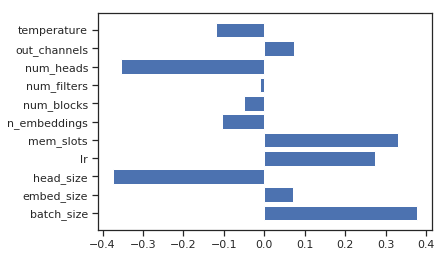

In [34]:
Y = search_results[['transition_score', 'chi-squared_score', 'indv_score', 'similarity_score']]
Y = (Y / Y.mad()).sum(axis = 1)
print(Y.shape)

print(Y.describe())
print(search_results.iloc[Y.idxmin()])
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(X, Y))
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ * X.mad(), 
    tick_label=X.columns
)
plt.show()

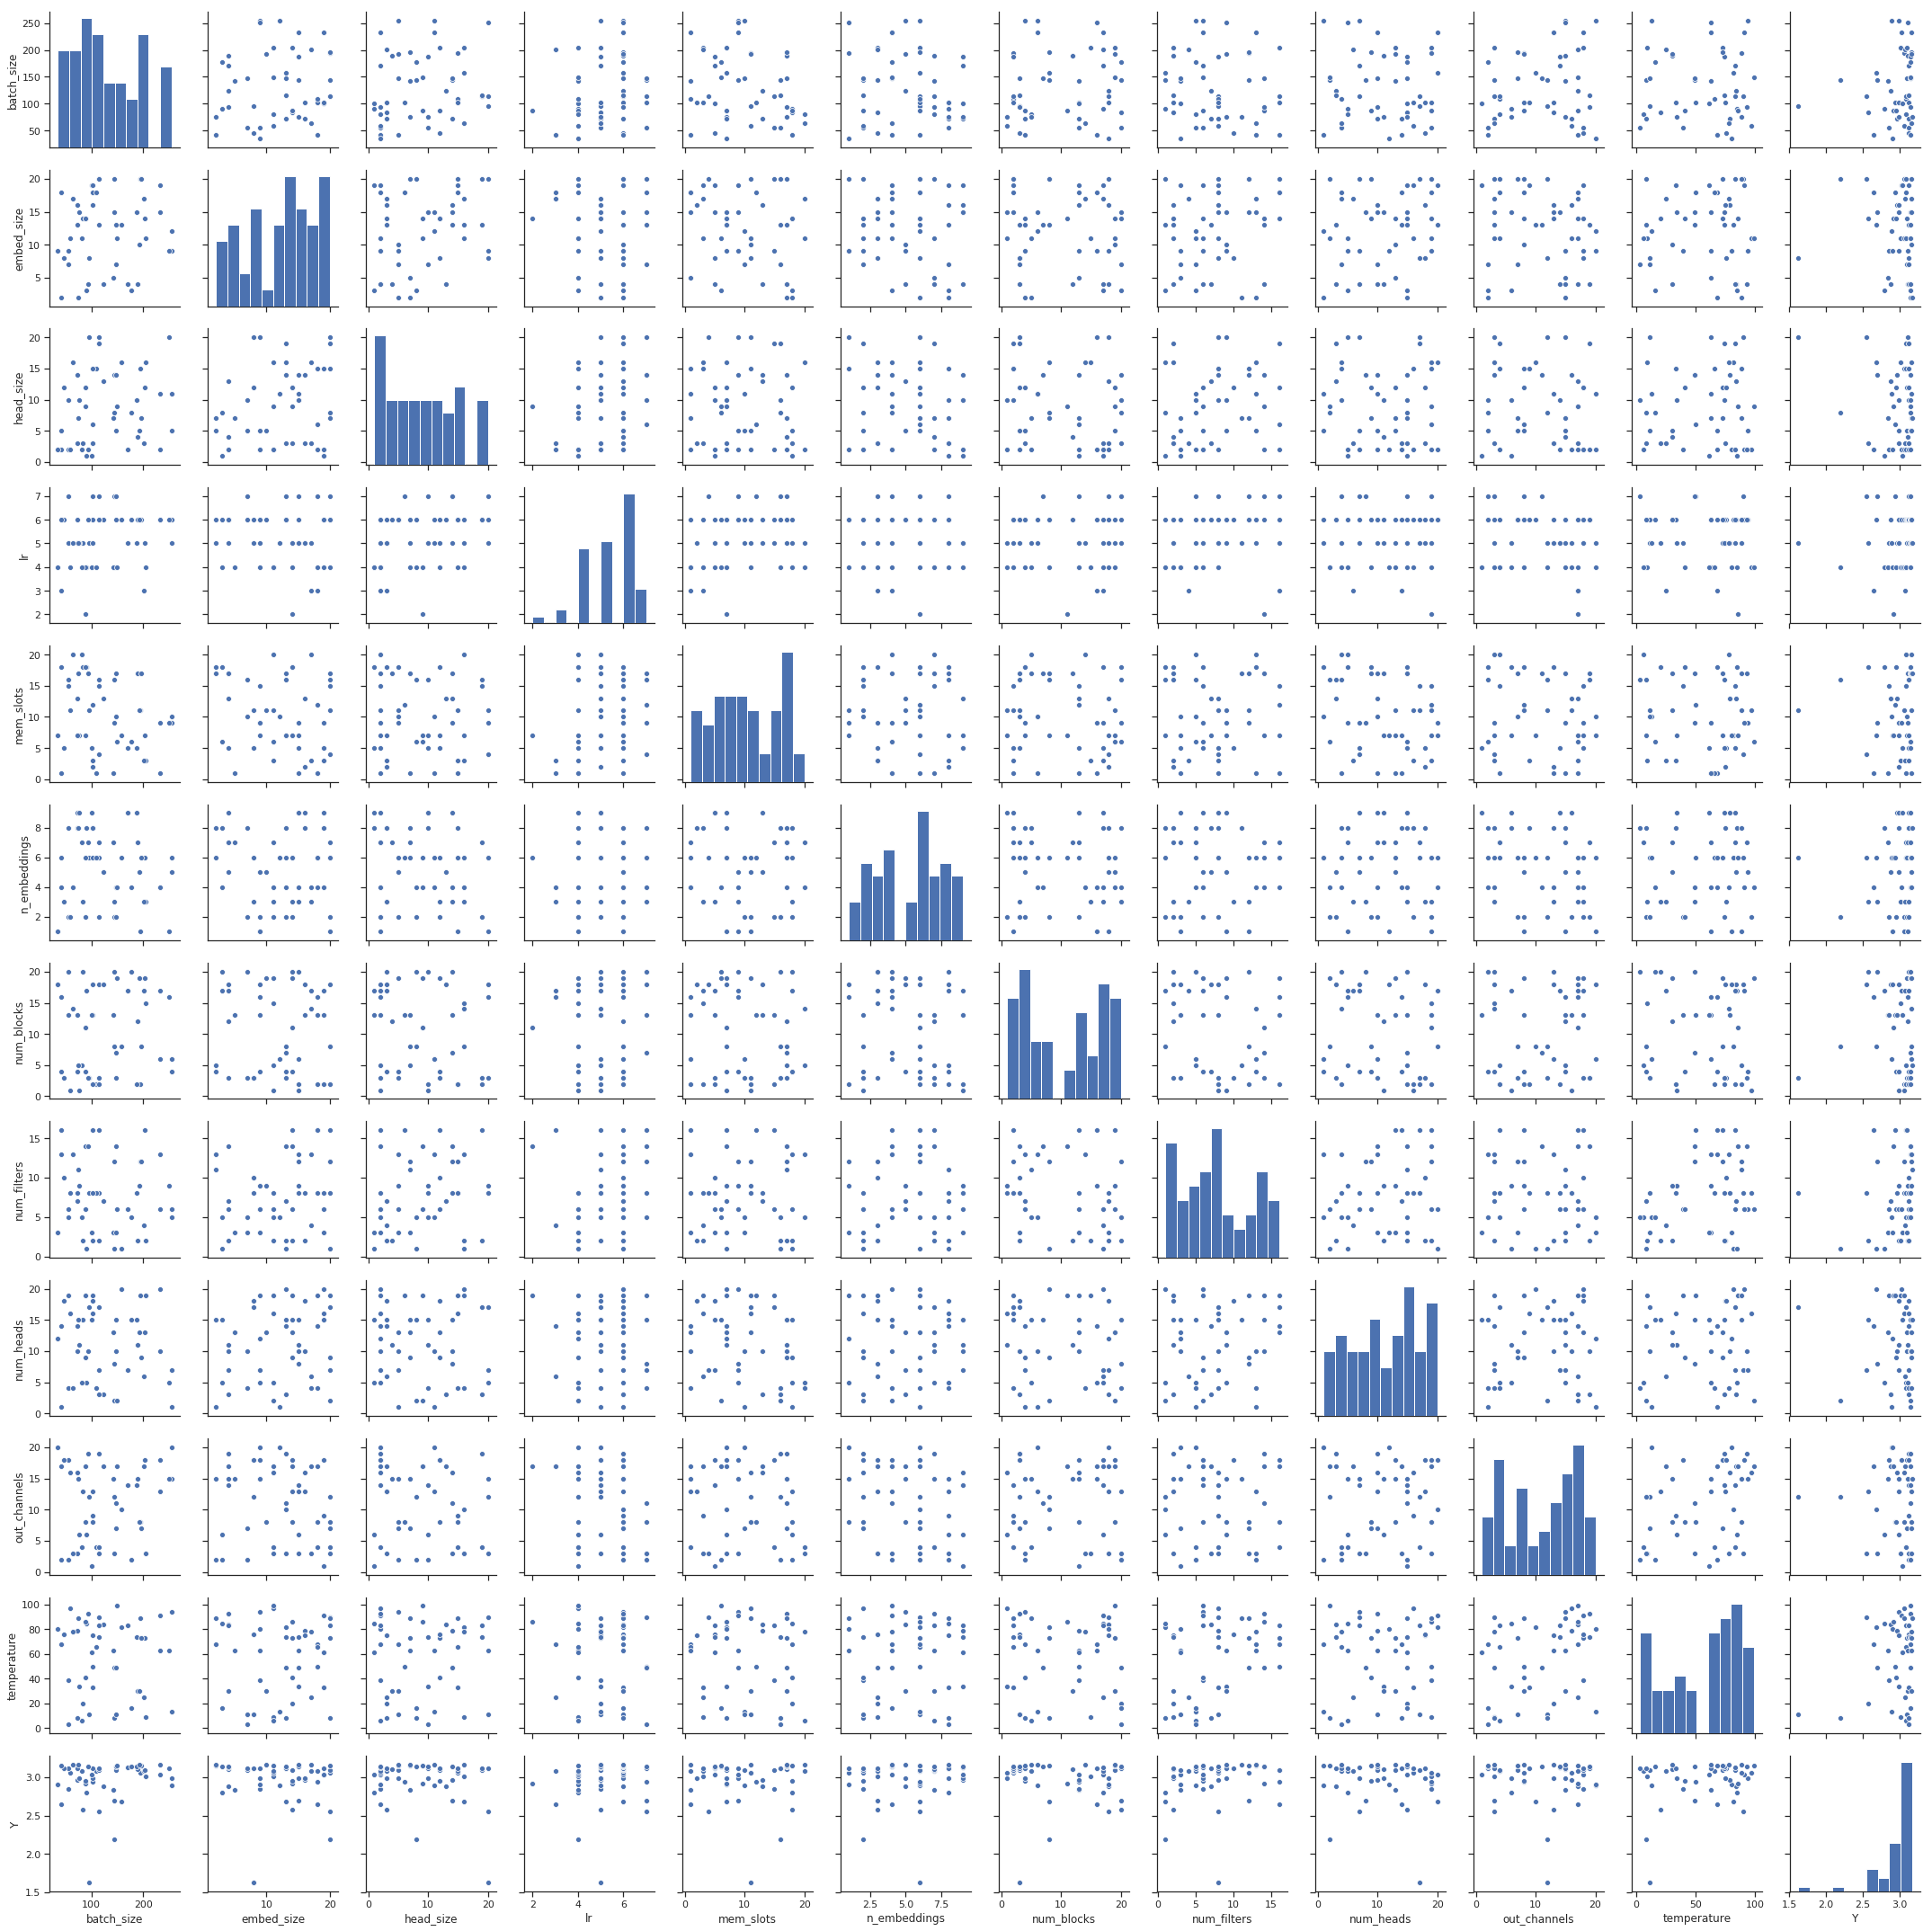

In [37]:
results = X.copy()
results['Y'] = Y

results = results.sort_values(by = 'Y')[:50]

sns.pairplot(results)

In [29]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size - 2)

    for i in range(2, vocab_size):
        if fake:
            counts[i - 2] = torch.sum(data == i)
        else:
            counts[i - 2] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [80]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

endpoints = ['I9_HYPTENS', 'I9_ANGINA', 'I9_HEARTFAIL_NS', 'I9_STR_EXH', 'I9_CHD', 'C3_BREAST']

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 30_000_000)

print(events.columns)

# include all endpoints in a list
events = events[events['ENDPOINT'].isin(endpoints)]
#events = events.groupby('FINNGENID').filter(lambda x: len(x) > 1)
events = events[events['EVENT_YEAR'] >= 2000]

print(len(events))

filename = 'data/FINNGEN_MINIMUM_DATA_R3_V1.txt'

patients = pd.read_csv(filename, compression = 'infer', sep='\t')
events = pd.merge(events, patients[['FINNGENID', 'SEX']])
events.columns

print(len(events))

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)
print(events['ENDPOINT'].unique())

Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
111381
111381
10564
['I9_HEARTFAIL_NS' 'I9_ANGINA' 'I9_CHD' 'I9_HYPTENS' 'I9_STR_EXH'
 'C3_BREAST']
CPU times: user 20.8 s, sys: 1.72 s, total: 22.6 s
Wall time: 22.2 s


In [81]:
%%time

print(events.groupby('FINNGENID').apply(lambda x: x['EVENT_AGE'].max() - x['EVENT_AGE'].min()).describe())
print(events.groupby('FINNGENID').apply(lambda x: len(x)).describe())
#print(events.groupby('FINNGENID')['SEX'].first())
print(events.groupby('ENDPOINT')['FINNGENID'].count())

count    10564.000000
mean         4.606916
std          5.363646
min          0.000000
25%          0.000000
50%          2.040000
75%          8.580000
max         17.990000
dtype: float64
count    10564.000000
mean        10.543449
std         17.228485
min          1.000000
25%          2.000000
50%          4.000000
75%         11.000000
max        309.000000
dtype: float64
ENDPOINT
C3_BREAST            854
I9_ANGINA           6926
I9_CHD              6495
I9_HEARTFAIL_NS    63707
I9_HYPTENS         28071
I9_STR_EXH          5328
Name: FINNGENID, dtype: int64
CPU times: user 2.75 s, sys: 4 ms, total: 2.75 s
Wall time: 2.75 s


In [82]:
def get_sequence_of_codes(subject):
    codes = ['None' for _ in range(2017 - 2000 + 1)]
    
    years = subject.groupby('EVENT_YEAR')
    
    for g, year in years:
        if year['ENDPOINT'].isin(['C3_BREAST']).any():
            value = 'C3_BREAST'
        elif year['ENDPOINT'].isin(['I9_CHD']).any():
            value = 'I9_CHD'
        else:
            value = np.random.choice(year['ENDPOINT'])
        codes[g - 2000] = value
        
    res = ' '.join(codes)
    return res

def get_age(subject):
    event = subject.sort_values('EVENT_AGE').iloc[0]
    
    age = event['EVENT_AGE'] + 2000 - event['EVENT_YEAR']
        
    return age


In [83]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

ages = events.groupby('FINNGENID').apply(get_age)
print(ages.shape)

sexes = events.groupby('FINNGENID')['SEX'].first()
sexes.shape

count    10564.0
mean        18.0
std          0.0
min         18.0
25%         18.0
50%         18.0
75%         18.0
max         18.0
dtype: float64
(10564,)
(10564,)
CPU times: user 53.1 s, sys: 48 ms, total: 53.1 s
Wall time: 53.1 s


(10564,)

In [84]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINT': sequences_of_codes, 'AGE': ages, 'SEX': sexes})
print(sequences.shape)
#sequences.head()


(10564, 3)


In [85]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [86]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(tokenize = tokenize)
AGE = Field(sequential = False, use_vocab = False)
SEX = Field()

fields = [('ENDPOINT', ENDPOINT), ('AGE', AGE), ('SEX', SEX)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)
#print(val.examples[0].__dict__)

ENDPOINT.build_vocab(train, val)
SEX.build_vocab(train, val)

(9507, 3) (1057, 3)
CPU times: user 588 ms, sys: 4 ms, total: 592 ms
Wall time: 590 ms


In [87]:
print(ENDPOINT.vocab.stoi['None'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs)

print(ENDPOINT.vocab.itos)

print(SEX.vocab.stoi['male'])
print(SEX.vocab.stoi['female'])
print(SEX.vocab.freqs)


2
None
9
Counter({'None': 155914, 'I9_HEARTFAIL_NS': 15318, 'I9_HYPTENS': 11610, 'I9_CHD': 3384, 'I9_ANGINA': 1716, 'I9_STR_EXH': 1486, 'C3_BREAST': 724})
['<unk>', '<pad>', 'None', 'I9_HEARTFAIL_NS', 'I9_HYPTENS', 'I9_CHD', 'I9_ANGINA', 'I9_STR_EXH', 'C3_BREAST']
3
2
Counter({'female': 5481, 'male': 5083})


In [88]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

print(next(iter(val_iter)).ENDPOINT.transpose(0, 1).shape)
print(next(iter(val_iter)).AGE.shape)
print(next(iter(val_iter)).SEX.view(-1).shape)

torch.Size([1057, 18])
torch.Size([1057])
torch.Size([1057])


torch.Size([1057])


(array([ 11.,  18.,  47., 133., 223., 305., 205.,  86.,  21.,   8.]),
 array([10. , 18.3, 26.6, 34.9, 43.2, 51.5, 59.8, 68.1, 76.4, 84.7, 93. ]),
 <a list of 10 Patch objects>)

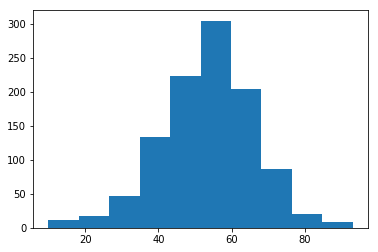

In [89]:
def get_age_distribution(dataset, dummy_batch_size = 128):
    res = []
    
    iterator = Iterator(dataset, batch_size = dummy_batch_size)
    
    for batch in iterator:
        res.append(batch.AGE)
        
    return torch.cat(res)
    
age_dist = get_age_distribution(val)
    
print(age_dist.shape)

plt.hist(age_dist.numpy())

In [90]:
def plot_data(data, ages, sexes, N=10, save=True):
    data = data[:N, :].numpy()
    
    new_data = np.empty(data.shape, dtype = 'object')
    for row, col in itertools.product(range(data.shape[0]), range(data.shape[1])):
        new_data[row, col] = ENDPOINT.vocab.itos[data[row, col]]
    
    cmap = {
        'None': '#ffffff',
    }
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = catheat.heatmap(new_data, cmap = cmap, ax = ax, linewidths = .5, leg_pos = 'top')
    
    labels = list(map(lambda x: SEX.vocab.itos[sexes[x]] + ', ' + str(int(ages[x])), range(N)))
    plt.yticks(np.arange(N) + 0.5, labels, rotation = 0)
    
    if save:
        plt.savefig('figs/catheat.svg')
    else:
        plt.show()
            

    
batch = next(iter(val_iter))

data = batch.ENDPOINT.transpose(0, 1)
ages = batch.AGE
sexes = batch.SEX.view(-1)

N = 15

#plot_data(data, ages, sexes, N, False)


In [91]:
'''
iterator = Iterator(val, 5)

batch = next(iter(iterator))

age = batch.AGE
print(age)
ages = age.view(-1, 1).type(Tensor) + torch.arange(3, dtype=torch.float32, device=device)
print(ages)
age = ages[:, 1].view(-1, 1)
print(age)

sex = batch.SEX
print(sex)
sex = (sex.view(-1, 1) - 2).type(Tensor)
print(sex)
print(sex.repeat(1, 3))

test = torch.randn(5, 2).type(Tensor)
print(test)
test = torch.cat([test, age / 100, sex], dim = 1)
print(test)
test.unsqueeze(dim=1).shape
'''


'\niterator = Iterator(val, 5)\n\nbatch = next(iter(iterator))\n\nage = batch.AGE\nprint(age)\nages = age.view(-1, 1).type(Tensor) + torch.arange(3, dtype=torch.float32, device=device)\nprint(ages)\nage = ages[:, 1].view(-1, 1)\nprint(age)\n\nsex = batch.SEX\nprint(sex)\nsex = (sex.view(-1, 1) - 2).type(Tensor)\nprint(sex)\nprint(sex.repeat(1, 3))\n\ntest = torch.randn(5, 2).type(Tensor)\nprint(test)\ntest = torch.cat([test, age / 100, sex], dim = 1)\nprint(test)\ntest.unsqueeze(dim=1).shape\n'

In [92]:
%%time

def get_transition_matrix(data, vocab_size, d = 1, ignore_time = False, eps = 1e-20):
    if ignore_time:
        transition_count = torch.zeros(vocab_size - 3, vocab_size - 3, 2) # no <unk>, <pad>, or None
        
        # This assumes that the index of 'None' is 2
        for indv in data:
            indv_not_none = indv[indv > 2]
            for idx in range(len(indv_not_none) - 1):
                i1 = idx
                ep1 = indv_not_none[i1]
                for ep2 in range(3, vocab_size):
                    if (indv_not_none[i1+1:] == ep2).any():
                        transition_count[ep1 - 3, ep2 - 3, 1] += 1
                    else:
                        transition_count[ep1 - 3, ep2 - 3, 0] += 1
        
        #print(torch.sum(transition_count, dim = -1))    
        transition_freq = (transition_count.permute(2, 0, 1) / (torch.sum(transition_count, dim = -1) + eps)).permute(1, 2, 0)
        
    else:
        transition_count = torch.zeros(vocab_size - 2, vocab_size - 2)

        for indv in data:
            for idx in range(len(indv) - d):
                i1 = idx
                i2 = i1 + d
                ep1 = indv[i1]
                ep2 = indv[i2]
                if ep1 > 1 and ep2 > 1:
                    transition_count[ep1 - 2, ep2 - 2] += 1

        #print(torch.sum(transition_count, dim = 1))
        transition_freq = (transition_count.transpose(0, 1) / (torch.sum(transition_count, dim = 1) + eps)).transpose(0, 1)
                    
    return transition_count, transition_freq
        
iterator = Iterator(train, batch_size = len(train_sequences))

transition_count, transition_freq = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, ignore_time = True)    
print(transition_count)
print(transition_freq)
print(transition_freq.sum(dim = -1))


tensor([[[9.1400e+02, 1.0386e+04],
         [8.9550e+03, 2.3450e+03],
         [9.2590e+03, 2.0410e+03],
         [1.0964e+04, 3.3600e+02],
         [1.0833e+04, 4.6700e+02],
         [1.1152e+04, 1.4800e+02]],

        [[4.2150e+03, 2.1820e+03],
         [1.4570e+03, 4.9400e+03],
         [5.5010e+03, 8.9600e+02],
         [6.0460e+03, 3.5100e+02],
         [5.9530e+03, 4.4400e+02],
         [6.2720e+03, 1.2500e+02]],

        [[8.2500e+02, 8.5400e+02],
         [1.1220e+03, 5.5700e+02],
         [8.1500e+02, 8.6400e+02],
         [1.3870e+03, 2.9200e+02],
         [1.5520e+03, 1.2700e+02],
         [1.6580e+03, 2.1000e+01]],

        [[5.6000e+02, 4.8900e+02],
         [5.9700e+02, 4.5200e+02],
         [6.6900e+02, 3.8000e+02],
         [6.8400e+02, 3.6500e+02],
         [9.6000e+02, 8.9000e+01],
         [1.0360e+03, 1.3000e+01]],

        [[4.5700e+02, 3.1300e+02],
         [4.7000e+02, 3.0000e+02],
         [6.3200e+02, 1.3800e+02],
         [7.3400e+02, 3.6000e+01],
         [3.

In [93]:
%%time

iterator = Iterator(train, batch_size = len(train_sequences))

transition_count1, transition_freq1 = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    
transition_count2, transition_freq2 = get_transition_matrix(next(iter(val_iter)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    

print(transition_freq1)
print(transition_freq2)
print((transition_freq1 - transition_freq2).abs().mean())


tensor([[0.8914, 0.0241, 0.0516, 0.0143, 0.0078, 0.0065, 0.0042],
        [0.1829, 0.7204, 0.0430, 0.0377, 0.0061, 0.0077, 0.0023],
        [0.6551, 0.0674, 0.2428, 0.0163, 0.0086, 0.0078, 0.0020],
        [0.6521, 0.1442, 0.0502, 0.1143, 0.0305, 0.0074, 0.0014],
        [0.6893, 0.0727, 0.0624, 0.0528, 0.1132, 0.0082, 0.0014],
        [0.6207, 0.0929, 0.0805, 0.0216, 0.0033, 0.1784, 0.0025],
        [0.8752, 0.0608, 0.0515, 0.0094, 0.0000, 0.0000, 0.0031]])
tensor([[0.8916, 0.0239, 0.0511, 0.0143, 0.0078, 0.0064, 0.0049],
        [0.2036, 0.6873, 0.0542, 0.0333, 0.0070, 0.0108, 0.0039],
        [0.6474, 0.0698, 0.2447, 0.0130, 0.0102, 0.0121, 0.0028],
        [0.6473, 0.1370, 0.0479, 0.1164, 0.0377, 0.0137, 0.0000],
        [0.7152, 0.0909, 0.0606, 0.0242, 0.1030, 0.0061, 0.0000],
        [0.6809, 0.0780, 0.0709, 0.0000, 0.0071, 0.1631, 0.0000],
        [0.8916, 0.0723, 0.0241, 0.0000, 0.0000, 0.0120, 0.0000]])
tensor(0.0087)
CPU times: user 11.7 s, sys: 4 ms, total: 11.7 s
Wall time:

In [94]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
sequence_length = 2017 - 2000 + 1
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

10564
4.73305566073457e-05


In [95]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[2]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    memory = memory.cuda()
    start_token = start_token.cuda()

print(memory)
logits, tokens, memory = G(start_token, torch.tensor([[20]]), torch.tensor([[2]]), memory, sequence_length)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.]]], device='cuda:0',
       g

In [96]:
%%time

# Define generator evaluation functions

def get_real_and_fake_data(G, dataset, batch_size, sequence_length):
    iterator = Iterator(dataset, batch_size = batch_size)
    
    if cuda:
        G.cuda()
    
    data = []
    data_fake = []
    
    for batch in iterator:
        data_tmp = batch.ENDPOINT.transpose(0, 1)
        data.append(data_tmp)

        start_tokens = data_tmp[:, :1]

        if cuda:
            start_tokens = start_tokens.cuda()

        _, data_fake_tmp, _ = G(start_tokens, batch.AGE, batch.SEX.view(-1), None, sequence_length)
        
        data_fake.append(data_fake_tmp.cpu())
    
    data = torch.cat(data)
    data_fake = torch.cat(data_fake)

    return data, data_fake
    
def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / (n + eps)
    col_freqs = col_sums / (n + eps)
    row_freqs = row_sums / (n + eps)
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance
    
def get_score(data_fake, ENDPOINT, vocab_size):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

def get_transition_score(data, data_fake, d, ignore_time, separate, vocab_size):
    transition_count_real, transition_freq_real = get_transition_matrix(data, vocab_size, d, ignore_time)
    transition_count_fake, transition_freq_fake = get_transition_matrix(data_fake, vocab_size, d, ignore_time)
    
    if ignore_time:
        res = torch.zeros(transition_count_real.shape[:2])
        
        for i in range(vocab_size - 3):
            for j in range(vocab_size - 3):
                res[i, j] = chi_sqrd_dist(transition_count_fake[i, j, :], transition_count_real[i, j, :])
                
        if separate:
            return res
        
        return torch.mean(res, dim = 1)
        
    else:
        chi_sqrd_ds = []
        for i in range(transition_count_real.shape[0]):
            chi_sqrd_d = chi_sqrd_dist(transition_count_fake[i, :], transition_count_real[i, :])
            chi_sqrd_ds.append(chi_sqrd_d)

        chi_sqrd_ds = torch.tensor(chi_sqrd_ds)

        if separate:
            return chi_sqrd_ds

        return torch.mean(chi_sqrd_ds)
    
def get_aggregate_transition_score(data, data_fake, ignore_time, separate1, separate2, vocab_size, sequence_length):
    if ignore_time:
        result = get_transition_score(data, data_fake, None, True, separate1, vocab_size)
    else:
        scores = []
        for d in range(1, sequence_length):
            transition_score = get_transition_score(data, data_fake, d, False, separate1, vocab_size)
            scores.append(transition_score)

        result = torch.stack(scores)

    if separate2:
        return result

    if separate1:
        return torch.mean(result, dim = 0)
    else:
        return torch.mean(result)
    
def get_similarity_score(data, data_fake, separate):
    n = data.shape[0]
    res = torch.zeros(n, n)
    
    for i in range(n):
        res[:, i] = (data == data_fake[i]).all(dim = 1)
        
    res = res.byte().any(dim = 1).float()
    
    if separate:
        return res
            
    return res.mean()
    
    
def get_individual_distribution(data, vocab_size, sequence_length):
    individual_counts = torch.zeros(vocab_size - 3, sequence_length + 1)
    
    for indv in data:
        for v in range(3, vocab_size):
            count = torch.sum(indv == v)
            individual_counts[v - 3, count] += 1
            
    individual_freqs = (individual_counts.transpose(0, 1) / torch.sum(individual_counts, dim = 1)).transpose(0, 1)
    
    return individual_counts, individual_freqs


def get_individual_score(data, data_fake, separate, vocab_size, sequence_length):
    individual_counts_real, individual_freqs_real = get_individual_distribution(data, vocab_size, sequence_length)
    
    individual_counts_fake, individual_freqs_fake = get_individual_distribution(data_fake, vocab_size, sequence_length)
    
    individual_scores = torch.zeros(individual_counts_real.shape[0])
    
    for i in range(individual_counts_real.shape[0]):
        individual_scores[i] = chi_sqrd_dist(individual_counts_fake[i, :], individual_counts_real[i, :])
        
    if separate:
        return individual_scores
    
    return individual_scores.mean()



data, data_fake = get_real_and_fake_data(G, val, batch_size, sequence_length)

score = get_score(data_fake, ENDPOINT, vocab_size)
print(score)

transition_score = get_transition_score(data, data_fake, None, True, True, vocab_size)
print(transition_score)

aggr_transition_score = get_aggregate_transition_score(data, data_fake, True, True, True, vocab_size, sequence_length)
print(aggr_transition_score)

sim = get_similarity_score(data, data_fake, False)
print(sim)
#print(sim.mean())

indv_score = get_individual_score(data, data_fake, True, vocab_size, sequence_length)

print(indv_score)



tensor(5.6916)
tensor([[1.5537e+00, 5.3444e-01, 3.5332e-01, 1.2774e+00, 2.8628e-01, 3.4696e+00],
        [1.0082e-02, 1.4676e-01, 2.3892e-01, 8.9772e-01, 1.1343e-01, 3.9337e+00],
        [2.1117e-01, 2.8696e-01, 2.0382e-02, 6.8366e-01, 1.7973e-01, 7.6325e+00],
        [2.7991e-01, 5.6299e-02, 1.2473e-02, 4.2058e-02, 1.3247e-01, 8.5365e+00],
        [5.1654e-05, 4.6025e-01, 2.8451e-01, 1.2979e+00, 2.4497e-01, 8.5137e+00],
        [4.1469e-01, 2.2479e-02, 1.8054e-01, 7.2424e-01, 5.4655e-02, 1.2815e+01]])
tensor([[1.5537e+00, 5.3444e-01, 3.5332e-01, 1.2774e+00, 2.8628e-01, 3.4696e+00],
        [1.0082e-02, 1.4676e-01, 2.3892e-01, 8.9772e-01, 1.1343e-01, 3.9337e+00],
        [2.1117e-01, 2.8696e-01, 2.0382e-02, 6.8366e-01, 1.7973e-01, 7.6325e+00],
        [2.7991e-01, 5.6299e-02, 1.2473e-02, 4.2058e-02, 1.3247e-01, 8.5365e+00],
        [5.1654e-05, 4.6025e-01, 2.8451e-01, 1.2979e+00, 2.4497e-01, 8.5137e+00],
        [4.1469e-01, 2.2479e-02, 1.8054e-01, 7.2424e-01, 5.4655e-02, 1.2815e+01]])

In [17]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0.5942, 0.5903]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.5922], device='cuda:0', grad_fn=<MeanBackward2>)


In [18]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, batch.AGE, batch.SEX, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [19]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)
    
score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 2, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

tensor(0.3332)
tensor([[3.1501, 0.4413, 2.4795, 0.8596, 0.3531, 1.3549],
        [1.5915, 0.5093, 2.7898, 0.6782, 0.1614, 1.4908],
        [1.0000, 0.5874, 1.9401, 0.3692, 0.3916, 1.9036],
        [0.0000, 0.4176, 1.6537, 0.7870, 0.9444, 1.3333]])
tensor(1.1328)
[Epoch 0/2] [G loss: 4.915725]
[Epoch 1/2] [G loss: 4.633242]
tensor(0.0546)
tensor([[1.5259, 0.6375, 1.6095, 0.6953, 0.8018, 2.0506],
        [1.9493, 0.7160, 0.6719, 1.3088, 1.3030, 1.5187],
        [1.0000, 0.7887, 0.9804, 1.3968, 0.6902, 0.2657],
        [0.0000, 0.4144, 0.8132, 0.1709, 0.7333, 1.5556]])
tensor(0.9832)


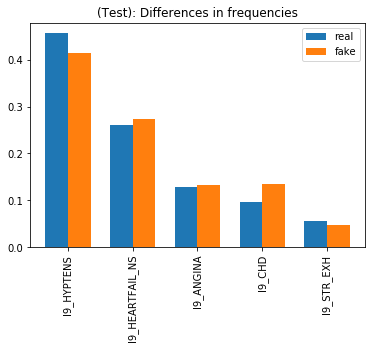

In [20]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx + 2), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix='', N_max=10):
    N = min(N_max, vocab_size - 2)
    if not prefix == '':
        prefix += ' '
    
    if N == vocab_size - 2:
        idx = np.arange(N)
        
        title = prefix + 'Differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    else:
        abs_diffs = np.abs(freqs - freqs_fake)
        idx = np.argsort(abs_diffs)[-N:]
        idx = np.flip(idx)
        
        title = prefix + 'Largest absolute differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)

        chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
        idx = np.argsort(chi_sqrd_dists)[-N:]
        idx = np.flip(idx)

        title = prefix + 'Largest relative differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

In [21]:
# Define the training function

def get_scores(G, ENDPOINT, dataset, batch_size = 128, separate1 = True, separate2 = True, \
               vocab_size = vocab_size, sequence_length = sequence_length):
    start_tokens = next(iter(iterator)).ENDPOINT.transpose(0, 1)[:, :1]
    
    score1 = get_score(G, ENDPOINT, dataset, batch_size, vocab_size, sequence_length)
    
    score2 = get_aggregate_transition_score(G, dataset, batch_size, separate1, separate2, vocab_size, sequence_length)
    
    return score1, score2.mean(), score2

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_scores):    
    scores = []
    accuracies_real = []
    accuracies_fake = []
    
    score = score_fn(G, ENDPOINT, val)
    print('Scores before training:', *score)
    scores.append(score)
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val)
    print("[Scores:", *score, "]")
    scores.append(score)
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0]).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0]).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, batch.AGE, batch.SEX, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot).view(-1), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            D_out_real = D(train_data_one_hot, batch.AGE, batch.SEX).view(-1)
            D_out_fake = D(fake_one_hot.detach(), batch.AGE, batch.SEX).view(-1)
            
            #print(D_out_real)
            #print(torch.round(D_out_real))
            accuracy_real = torch.mean(D_out_real)
            accuracy_fake = torch.mean(1 - D_out_fake)
            
            real_loss = adversarial_loss(D_out_real, valid)
            fake_loss = adversarial_loss(D_out_fake, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print()
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [Acc real: %f] [Acc fake: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item(), accuracy_real, accuracy_fake)
            )
            score = score_fn(G, ENDPOINT, val)
            print("[Scores:", *score, "]")
            scores.append(score)
            accuracies_real.append(accuracy_real)
            accuracies_fake.append(accuracy_fake)
            
    score = score_fn(G, ENDPOINT, val)
    print('Scores after training:', *score)
    scores.append(score)
            
    output = [[] for _ in range(len(scores[0]))]
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            output[j].append(scores[i][j])

    output.append(accuracies_real)
    output.append(accuracies_fake)
            
    for j in range(len(output)):
        output[j] = torch.stack(output[j])
            
    return tuple(output)


Scores before training: tensor(0.2726) tensor(1.1840) tensor([[3.0244, 0.8414, 1.6349, 0.4987, 0.1370, 1.2153],
        [3.7533, 0.9779, 1.7311, 0.2570, 0.3719, 2.2427],
        [1.0000, 0.8103, 2.5675, 0.4588, 0.2826, 1.6522],
        [0.0000, 0.8973, 1.4231, 1.5975, 0.4178, 0.6222]])
pretraining generator...
[Epoch 0/1] [G loss: 5.155181]
pretraining complete
[Scores: tensor(0.0715) tensor(0.9057) tensor([[2.0225, 0.6427, 2.0135, 1.0919, 0.6902, 1.6986],
        [1.8838, 0.6349, 1.0855, 0.9809, 0.5119, 2.1260],
        [1.0000, 0.5005, 0.9091, 0.2051, 0.3949, 0.7101],
        [0.0000, 0.3728, 0.4381, 0.2611, 0.8127, 0.7500]]) ]

[Epoch 0/10] [D loss: 0.693741] [G loss: 0.715832] [Acc real: 0.488462] [Acc fake: 0.511211]
[Scores: tensor(0.0272) tensor(1.1094) tensor([[2.3070, 0.7637, 1.1841, 0.7107, 0.6555, 2.6219],
        [2.1533, 0.4617, 1.0755, 0.5078, 0.8488, 2.1984],
        [1.0000, 0.4847, 1.9431, 0.7494, 1.4773, 1.8519],
        [0.0000, 0.3159, 0.7136, 0.1235, 1.1562, 1.3220

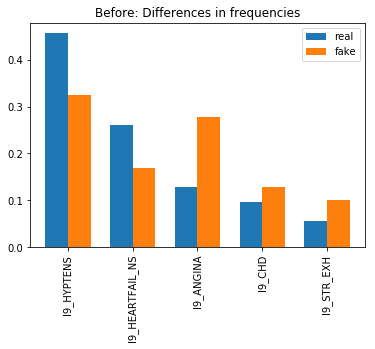

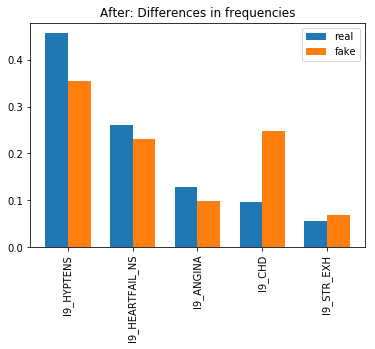

In [24]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 5
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)



batch_size = 64
n_epochs = 10
print_step = max(n_epochs // 10, 1)
lr = 1e-4

# Train the GAN
scores1, scores2, scores3, accuracies_real, accuracies_fake = train_GAN(
    G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step
)



counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


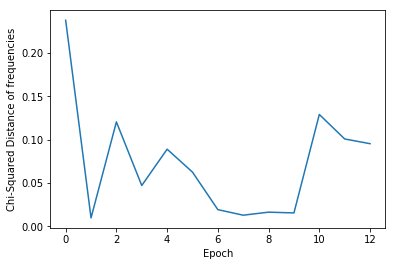

In [30]:
%matplotlib inline

plt.plot(range(scores1.shape[0]), scores1.numpy())
plt.ylabel('Chi-Squared Distance of frequencies')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd_freqs.svg')

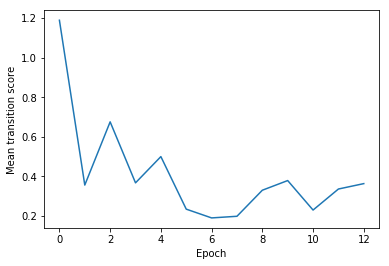

In [31]:
plt.plot(range(scores2.shape[0]), scores2.numpy())
plt.ylabel('Mean transition score')
plt.xlabel('Epoch')
plt.savefig('figs/mean_transition_score.svg')

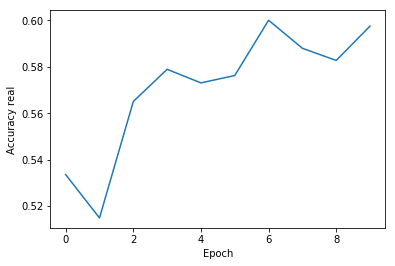

In [32]:
plt.plot(range(accuracies_real.shape[0]), accuracies_real.detach().cpu().numpy())
plt.ylabel('Accuracy real')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_real.svg')

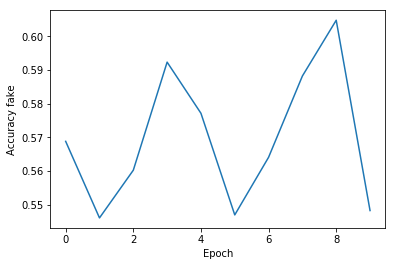

In [33]:
plt.plot(range(accuracies_fake.shape[0]), accuracies_fake.detach().cpu().numpy())
plt.ylabel('Accuracy fake')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_fake.svg')

In [34]:
for d in range(1, sequence_length):
    plt.plot(range(scores3.shape[0]), scores3[:, d - 1, :].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'd=' + str(d)
    plt.title(title)
    labels = [ENDPOINT.vocab.itos[i] for i in range(1, vocab_size)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [35]:
for v in range(1, vocab_size):
    plt.plot(range(scores3.shape[0]), scores3[:, :, v - 1].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'enpoint=' + ENDPOINT.vocab.itos[v]
    plt.title(title)
    labels = ['d=' + str(i) for i in range(1, sequence_length)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [36]:
test_size = 10
start_tokens = torch.randint(2, vocab_size, (test_size, 1))
print(start_tokens)

memory = G.initial_state(batch_size = test_size)

if cuda:
    memory = memory.cuda()
    start_tokens = start_tokens.cuda()
    
_, data_fake, _, _ = G(start_tokens, batch.AGE, batch.SEX, memory, sequence_length)

data_fake

tensor([[4],
        [4],
        [3],
        [3],
        [4],
        [6],
        [5],
        [3],
        [2],
        [3]])


tensor([[4, 4, 5, 5, 3],
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [4, 2, 1, 1, 1],
        [6, 6, 6, 6, 6],
        [5, 5, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [2, 2, 2, 2, 3],
        [3, 3, 3, 3, 3]], device='cuda:0')